### This is the implementation of Built-In DeepAR sagemaker model 
This is a supervised learning algorithm for forecasting scalar time series.
For more information please visit: https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html

In [1]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt

import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [2]:
sagemaker_session = sagemaker.Session()

region = sagemaker_session.boto_region_name
role = get_execution_role()

s3_bucket = "sagemaker-us-east-1-563718358426"
prefix = "tryouts"

s3_output_path = "s3://{}/{}/model".format(s3_bucket, prefix)

image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


### Add information about kaggle competition

In [3]:
df = pd.read_csv("train.csv", parse_dates= True, index_col=0)
df = df.resample("1h").mean()
df.head(5)
#I have no null values and have hourly data

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1.0,0.0,0.0,1.0,9.84,14.395,81.0,0.0,3.0,13.0,16.0
2011-01-01 01:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,8.0,32.0,40.0
2011-01-01 02:00:00,1.0,0.0,0.0,1.0,9.02,13.635,80.0,0.0,5.0,27.0,32.0
2011-01-01 03:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,3.0,10.0,13.0
2011-01-01 04:00:00,1.0,0.0,0.0,1.0,9.84,14.395,75.0,0.0,0.0,1.0,1.0


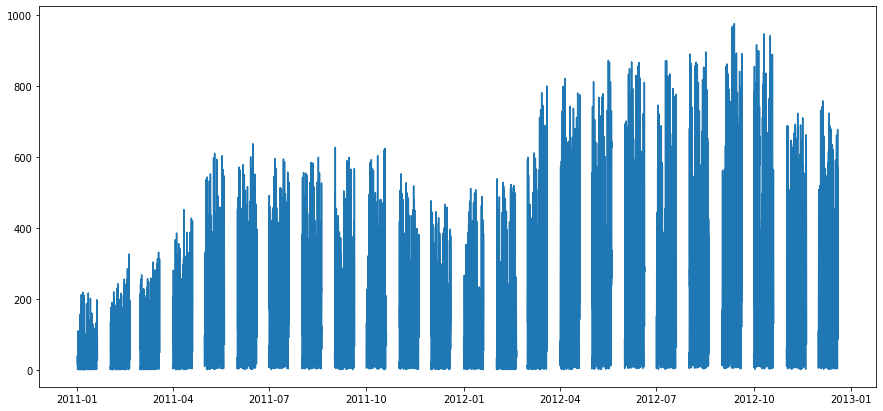

In [4]:
plt.figure(figsize=(15,7))
plt.plot(df["count"])
plt.show()

In [5]:
#12 days 
prediction_span = 24
context =  24

In [6]:
json_lines = []
count_lines = 0
for record in df.index:
    target =[str(i) for i in list(df.iloc[count_lines:count_lines + context*7, 10])]
    target =["NaN" if i == "nan" else round(float(i)) for i in target]
    if len(target) == context*7:
        dictionary = {"start":str(record), "target": target}
        json_lines.append(dictionary)
        count_lines += 1
    else:
        break

In [7]:
def write_dicts_to_file(path, data):
    with open(path, 'wb') as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode('utf-8'))

write_dicts_to_file("train.json", json_lines)

In [8]:
with open("train.json", "rb") as f:
    boto3.Session().resource("s3").Bucket(s3_bucket).Object(prefix + "/train/train.json").upload_fileobj(f)

In [9]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    base_job_name='deepAr-forecast',
    output_path=s3_output_path)

#time_freq for the frequency of the records, every hour
hyperparameters = {
    "time_freq": "1H",
    "epochs": "80",
    "early_stopping_patience": "10",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context),
    "prediction_length": str(prediction_span)}

estimator.set_hyperparameters(**hyperparameters)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [11]:
data_channels = {"train": "s3://"+ s3_bucket + "/" + prefix + "/train/train.json"}

estimator.fit(inputs=data_channels, wait=True)

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-07 01:20:27 Starting - Starting the training job...............
2020-09-07 01:22:35 Starting - Launching requested ML instances.........
2020-09-07 01:24:09 Starting - Preparing the instances for training......
2020-09-07 01:25:07 Downloading - Downloading input data...
2020-09-07 01:25:50 Training - Training image download completed. Training in progress.Arguments: train
[09/07/2020 01:25:52 INFO 139866244298560] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopp

In [12]:
#deepAr-forecast-2020-09-07-01-20-27-189 is the name
endpoint_name = sagemaker_session.endpoint_from_job(
    job_name="deepAr-forecast-2020-09-07-01-20-27-189",
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    deployment_image=image_name,
    role=role)

---------------!

In [18]:
boto3.client('sagemaker').delete_endpoint(EndpointName = endpoint_name)
#also delete the model